In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
class WeightsInitialization:
    def __init__(self, L_in, L_out):
        self.L_in = L_in
        self.L_out = L_out
        self.weight = None

    def InitializeLayer(self):
        L = np.random.rand(self.L_out, self.L_in + 1)
        self.weight = L

In [3]:
class Network:
    def __init__(self,layers):
        self.w=[]
        self.ai=[]
        self.cost=[]
        self.layers=layers
        for i in range(len(self.layers)-1):
            wi=WeightsInitialization(self.layers[i],self.layers[i+1])
            self.w.append(wi)
            self.w[i].InitializeLayer()
    
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))

    def d_sigmoid(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    
    def ForwardProp(self,w,x):
        self.ai=[]
        self.ai.append(x)
        input=x
        for i in range(len(self.layers)-1):
            b=self.w[i].weight[:,0].reshape(self.w[i].weight[:,0].shape[0],1)
            hyp=self.sigmoid(np.dot(self.w[i].weight[:,1:],input.T)+b).T
            input=hyp
            self.ai.append(hyp)
        
        return hyp
    
    def BackProp(self,h,y,l_rate):
        error = h.T - y
        for i in range(len(self.layers)-2,-1,-1):
            delta = error*self.d_sigmoid(self.ai[i+1]).T
    
            w_update = np.dot(delta,self.ai[i])
            b_update = delta.sum()
            
            self.w[i].weight[:,1:]-=(l_rate/len(y.T))*w_update
            self.w[i].weight[:,0]-=(l_rate/len(y.T))*b_update
            
            error = np.dot(self.w[i].weight[:, 1:].T, delta)
            
    
    def costFunc(self,hyp,y,m):
        return np.sum(np.subtract(hyp, y) ** 2) / m
    
    
    def l_curves(self,iters,l_rate):
        sns.set()
        plt.figure(dpi=100,figsize=(6,4))
        iters = [i * 200 for i in range(iters)]
        plt.plot(iters, self.cost,color="red",label="learning rate="+str(l_rate))
        plt.xlabel("iterations")
        plt.ylabel("cost")
        plt.title("learning curve")
        plt.legend()
        plt.show()
    
    def Train(self,x,y,iters,l_rate):
        for i in range(iters+1):
            h = self.ForwardProp(self.w,x)
            self.BackProp(h,y.T,l_rate)
            
            if i % 200 == 0:
                cost=self.costFunc(h, y, len(x))
                self.cost.append(cost)
        
    
    def predict(self, x):
        h = self.ForwardProp(self.w,x) 
        return np.argmax(h,axis=1)
    
    def accuracy(self,x,y):
        y_pred = self.predict(x)
        return (((y_pred == y).astype(int)).mean())*100

In [4]:
def Transform(y):
    for i in range(len(y)):
        y1=np.zeros(10)
        y1[y[i]]=1
        y[i]=y1
        
    return y      


Training...

training accuracy: 94.853 %

prediction: [1, 4, 2, 9, 5, 0, 4, 3, 8, 3, 8, 6, 9, 5, 1, 0, 3, 9, 4, 4, 9, 5, 1, 9, 7, 5, 1, 9, 7, 2, 8, 4, 6, 9]

real: [1, 4, 2, 9, 5, 0, 4, 3, 8, 3, 6, 6, 9, 5, 1, 0, 3, 9, 4, 4, 9, 5, 1, 9, 2, 5, 1, 9, 7, 2, 8, 5, 6, 9]

test accuracy: 91.176 %

time taken to train : 259.35 ms


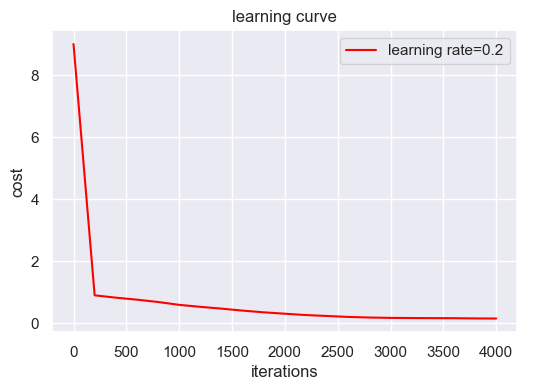

In [7]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

x=np.array([digits.data[i] for i in range(170)])
y=np.array(Transform([digits.target[i] for i in range(170)]))


X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2)


nn=Network([64,32,10])
learning_rate=0.2

print("\nTraining...")

st=time.time()
nn.Train(X_train,y_train,iters=4000,l_rate=learning_rate)  
et=time.time()
    
print("\ntraining accuracy: %0.3f" % nn.accuracy(X_train, np.argmax(y_train,axis=1)), "%")

pred = nn.predict(X_test)

print("\nprediction:",list(pred)) 

print("\nreal:",list(np.argmax(y_test,axis=1)))

print("\ntest accuracy: %0.3f" % nn.accuracy(X_test, np.argmax(y_test,axis=1)), "%")

print("\ntime taken to train : %0.2f"%((et-st)*100),"ms")

nn.l_curves(iters=21,l_rate=learning_rate)